In [ ]:
import os
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import imageio as iio
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torchvision.datasets import Food101 as Food
from torchvision.utils import save_image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Define the parameters for the training process
n_epochs = 100
batch_size = 128
lr = 0.0002
b1 = 0.5
b2 = 0.999
latent_dim = 100
mean = 0.5
std = 0.5

In [15]:
!mkdir "food_train"
!mkdir 'food_test'

# Data preprocessing

In [16]:
trans = transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize([mean], [std])
                           ])
dataset_train = Food(root="./food_train", download = True, transform = trans)
dataset_test = Food(root="./food_test", download = True, transform = trans, split = "test")

100%|██████████| 4996278331/4996278331 [05:02<00:00, 16498638.53it/s]


Extracting ./food_train/food-101.tar.gz to ./food_train


100%|██████████| 4996278331/4996278331 [05:25<00:00, 15354290.12it/s]


Extracting ./food_test/food-101.tar.gz to ./food_test


In [17]:
print('No. of train images:', len(dataset_train))
print('No. of test images:', len(dataset_test))

No. of train images: 75750
No. of test images: 25250


In [ ]:
dataset = dataset_train + dataset_test
dataset

In [41]:
# dataloader = DataLoader(dataset, batch_size= batch_size, shuffle= False)

# batch1 = iter(dataloader)
# for i in batch1:
#     print(batch1[i])
#     break
# # print(batch1)



RuntimeError: stack expects each tensor to be equal size, but got [3, 512, 512] at entry 0 and [3, 384, 512] at entry 3

In [28]:
# img_shape = dataset[0].shape
# channels, img_sizex, img_sizey = img_shape
# print(img_shape)
# print(channels)

AttributeError: 'tuple' object has no attribute 'shape'

TypeError: can't multiply sequence by non-int of type 'float'

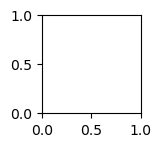

In [25]:
# plt.figure(figsize=(12,12))
# for i in range(64):
#   plt.subplot(8,8, i+1)
#   img = dataset[i] * std + mean # Denormalize the image: denormalized_image = (normalized_image * std) + mean
#   plt.imshow(img.permute(1, 2, 0))
#   plt.axis("off")

# DataLoader

# GAN Model

In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [56]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, normalize=True):
            layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
        # input is Z, going into a convolution
        *block(latent_dim, 512, 4, 1, 0, normalize=False),  # First layer block
            *block(512, 256, 4, 2, 1),  # 2nd layer block
     *block(256, 128, 4, 2, 1), # 3rd layer block
        *block(128, 64, 4, 2, 1),   # 4th layer block
        *block(64, 32, 4, 2, 1),    # Added a fifth layer block
        nn.ConvTranspose2d(32, channels, 3, 1, 1), # Final Convolutional layer
        nn.Tanh() # Tanh activation for output       
        )

    def forward(self,z): # Forward propagation function
#         print("z before exe in gen:", z.shape)
        z = z.view(z.size(0), z.size(1),1 ,1) # Reshape the input tensor in (B x C x H x W) format
#         print("z shape in gen:", z.shape)
#         print("z inside gen:", z)
        img = self.model(z) # Pass input through the model
        return img # Return the image


In [57]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Function to create a convolutional layer block (Conv -> LeakyReLU)
        def block(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
            return [
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                nn.LeakyReLU(0.2, inplace=True)
            ]

        self.model = nn.Sequential(
            *block(channels, 32),  # First layer block
            *block(32, 64),  # Second layer block
            *block(64, 128),  # Second layer block
            *block(128, 256),  # Third layer block
            *block(256, 512),  # Fourth layer block
            nn.Conv2d(512, 1, 2, 1, 0),  # Final convolutional layer
            nn.Sigmoid()  # Sigmoid activation for output
        )

    def forward(self, img):  # Forward propagation function
        validity = self.model(img)  # Pass the image through the model
#         validity = validity.view(validity.size(0), 1)  # Forcing the shape of the output
        validity = validity.view(validity.size(0), -1)  # Flatten the output
        return validity  # Return the validity

In [58]:
# # We use binary cross-entropy loss for the adversarial loss function
# adversarial_loss = torch.nn.BCELoss()

# # Initialize the generator and the discriminator
# generator = Generator()
# discriminator = Discriminator()

# # If CUDA is available, we use it for the models and the loss function
# if torch.cuda.is_available():
#     generator.cuda()
#     discriminator.cuda()
#     adversarial_loss.cuda()


# # We use the Adam optimizer for both the generator and the discriminator
# optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
# optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))


# # Initialize schedulers
# scheduler_G = lr_scheduler.StepLR(optimizer_G, step_size=30, gamma=0.1)
# scheduler_D = lr_scheduler.StepLR(optimizer_D, step_size=30, gamma=0.1)

# #
# Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [59]:
# !mkdir 'training_predictions01'

mkdir: cannot create directory ‘training_predictions01’: File exists


In [60]:
# # Initialize list to store losses for Generator and Discriminator
# g_losses = []
# d_losses = []

# # Training Loop
# for epoch in tqdm(range(n_epochs)):  # Loop over the dataset multiple times, for each epoch
#     g_loss_accum = 0.0
#     d_loss_accum = 0.0
#     num_batches = 0
#     for i, (imgs) in enumerate(dataloader):  # Loop over each batch of real images in the dataset
# #         print(imgs.shape)
#         # Ground truths for real and fake images (real: 1, fake: 0)
#         valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
#         fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

#         # Configure input, this will be used for training the discriminator with real images
#         real_imgs = Variable(imgs.type(Tensor))

#         # -----------------
#         #  Train Generator
#         # -----------------

#         optimizer_G.zero_grad()  # Clears the gradients of all optimized tensors
#         # Sample noise as generator input
#         z = Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim)))
# #         print(z.shape)
        
#         # zz = z.view(z.size(0), z.size(1), 1, 1) 
#         # print(zz.shape)

#         # Generate a batch of images from the noise
#         gen_imgs = generator(z)
# #         print(gen_imgs.shape)
# #         print(valid.shape)
# #         print(discriminator(gen_imgs).shape)


#         # Loss measures generator's ability to fool the discriminator
#         g_loss = adversarial_loss(discriminator(gen_imgs), valid)

#         g_loss.backward()  # Compute the gradient of g_loss w.r.t. the Generator's parameters
#         optimizer_G.step()  # Update the Generator's weights
       

#         # ---------------------
#         #  Train Discriminator
#         # ---------------------

#         optimizer_D.zero_grad()  # Clears the gradients of all optimized tensors

#         # Measure discriminator's ability to classify real from generated samples
#         real_loss = adversarial_loss(discriminator(real_imgs), valid)  # Loss for real images
#         fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)  # Loss for fake images
#         d_loss = (real_loss + fake_loss) / 2  # Take the average of these two losses

#         d_loss.backward()  # Compute the gradient of d_loss w.r.t. the Discriminator's parameters
#         optimizer_D.step()  # Update the Discriminator's weights
        

#         # Accumulate losses for this batch
#         g_loss_accum += g_loss.item()
#         d_loss_accum += d_loss.item()
#         num_batches += 1

#     # Step the learning rate
#     scheduler_G.step()
#     scheduler_D.step()

#     # Save average losses for this epoch
#     g_losses.append(g_loss_accum / num_batches)
#     d_losses.append(d_loss_accum / num_batches)
    
#         # Save a batch of generated images every 10 epochs
#     if epoch % 10 == 0 or epoch == 100:
#         save_image(gen_imgs.data[:25], f"/kaggle/working/training_predictions01/epoch_{epoch}.png", nrow=5, normalize=True)        

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_32/1229826153.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = iio.imread(f"{self.im_fol}{self.im_list[idx]}")
  0%|          | 0/100 [00:55<?, ?it/s]


FileNotFoundError: No such file: '/kaggle/input/cub-200-2011/cub_200_2011_64x64_for_fid_10k/cub_200_2011_64x64_10k/965.png'

In [ ]:
# # Plotting the losses
# plt.figure(figsize=(10,5))
# plt.title("Generator and Discriminator Loss During Training")
# plt.plot(g_losses,label="Generator")
# plt.plot(d_losses,label="Discriminator")
# plt.xlabel("epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()